In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from xgboost.callback import TrainingCallback
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

c:\Users\Saad-Asif\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset loading

In [56]:
dataset = load_dataset("ealvaradob/phishing-dataset", "urls", trust_remote_code=True)
df = pd.DataFrame(dataset['train'])

In [57]:
print("Dataset Columns:", df.columns)
print("First 5 Rows:\n", df.head())

Dataset Columns: Index(['text', 'label'], dtype='object')
First 5 Rows:
                                                 text  label
0      http://webmail-brinkster.com/ex/?email=%20%0%      1
1                         billsportsmaps.com/?p=1206      0
2  www.sanelyurdu.com/language/homebank.tsbbank.c...      1
3                          ee-billing.limited323.com      1
4                   indiadaily.com/bolly_archive.htm      0


# Data Analysis

In [58]:
# check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
text     0
label    0
dtype: int64


In [59]:
# Label Distribution
label_distribution = df['label'].value_counts()
print("\nLabel Distribution:")
print(label_distribution)


Label Distribution:
label
0    444933
1    390764
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


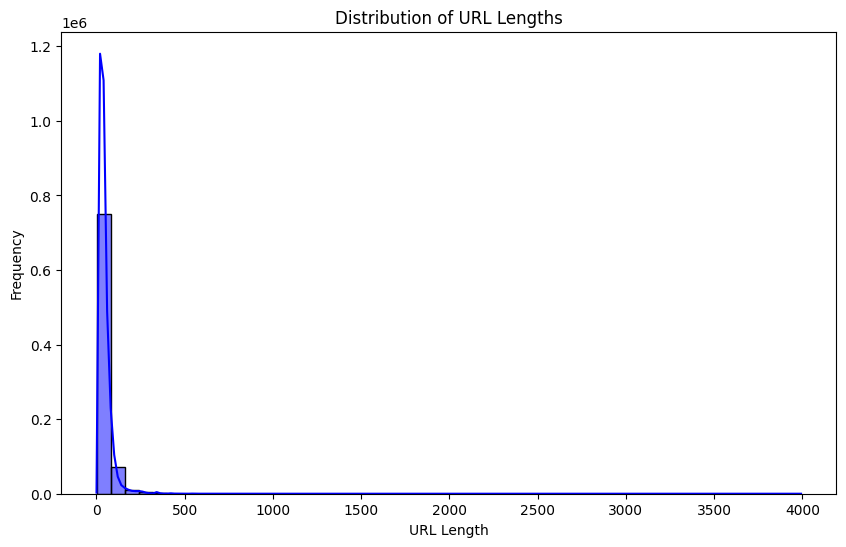

In [60]:
# URL length distribution
df['url_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['url_length'], bins=50, kde=True, color='blue')
plt.title("Distribution of URL Lengths")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

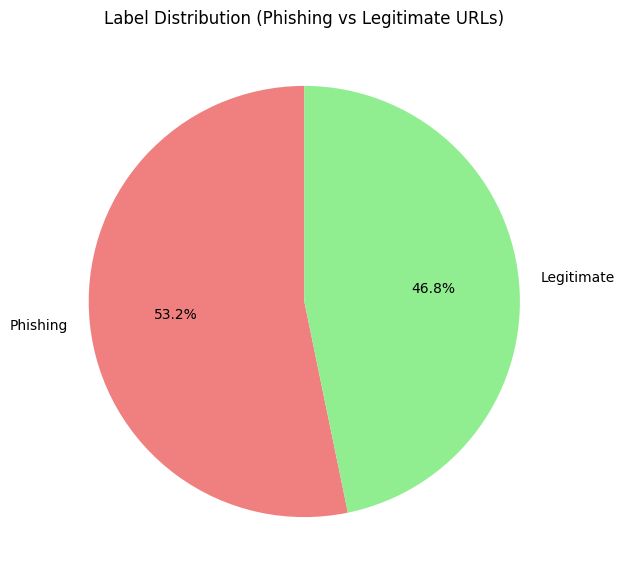

In [61]:
# Distribution of labels with color labels
plt.figure(figsize=(7, 7))
label_distribution.plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'], labels=['Phishing', 'Legitimate'])
plt.title("Label Distribution (Phishing vs Legitimate URLs)")
plt.ylabel('')
plt.show()

# Model Training

In [62]:
X = df['text']  
y = df['label'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Features Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

Training Features Shape: (668557,)
Training Labels Shape: (668557,)
Testing Features Shape: (167140,)
Testing Labels Shape: (167140,)


In [63]:
vectorizer = TfidfVectorizer(max_features=10000)  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, n_estimators=100)

class TQDMProgressBar(TrainingCallback):
    def __init__(self, total_steps):
        self.pbar = tqdm(total=total_steps, desc="Training Progress")
    
    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)  
        return False  
    
    def __del__(self):
        self.pbar.close()  

progress_bar_callback = TQDMProgressBar(total_steps=model.get_params()['n_estimators'])

model.fit(X_train_tfidf, y_train, callbacks=[progress_bar_callback])

Training Progress: 100%|██████████| 100/100 [40:54<00:00, 24.55s/it]
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
Training Progress: 100%|██████████| 100/100 [00:41<00:00,  2.76it/s]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Save the model

In [64]:
with open('Phishing Model 96.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

## Testing the model

In [65]:
train_accuracy = accuracy_score(y_train, model.predict(X_train_tfidf))
test_accuracy = accuracy_score(y_test, model.predict(X_test_tfidf))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8858
Testing Accuracy: 0.8845


In [66]:
urls = X_test[:100].values
predictions = model.predict(X_test_tfidf[:100])
true_labels = y_test[:100].values
print(f"{'Prediction':<12} {'True Label':<12} {'Status'} {'URL'}")
print("="*80)

for pred, true, url in zip(predictions, true_labels, urls):
    status = "CORRECT" if pred == true else "INCORRECT"
    color = 'green' if status == "CORRECT" else 'red'
    print(f"{pred:<12} {true:<12} {colored(status, color)} {url}")
    
accuracy = accuracy_score(true_labels, predictions)
print(f"\n\nAccuracy on first 100 samples: {accuracy:.4f}")

Prediction   True Label   Status URL
0            0            CORRECT www.mtsu.edu/~acsi/ASC.html
0            0            CORRECT bbc.co.uk/music/reviews/nwvh
0            0            CORRECT majorleaguesoccertalk.com/miami-fc-v-tampa-bay-rowdies-florida-derby-returns-this-weekend-8860
1            1            CORRECT paypal.id.security-log-in.cf
1            1            CORRECT http://grup-pemersatubangsaaa.duckdns.org/
1            1            CORRECT https://www.kueronekayaaetn.co.jp.chuzou8.cn/
0            0            CORRECT angelfire.com/sd/hardie/Coyle.html
1            1            CORRECT https://amaezom.cvlhwxe.cn/
1            1            CORRECT dbs.net.co
1            1            CORRECT droneview.tv/wp-includes
0            0            CORRECT answers.encyclopedia.com/question/founded-port-royal-78857.html
1            1            CORRECT colchesterhomesltd.co.uk/images/Americanexpress.com/index.html
0            0            CORRECT https://login.bce.baidu.c